In [20]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
from tqdm import tqdm
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Directory: 170309_150338_M018V6_Greater_Trap_Area_V6.3_res_guard_sweep


100%|██████████| 138/138 [03:44<00:00,  1.61s/it]


KeyError: 'Unable to open object (Component not found)'

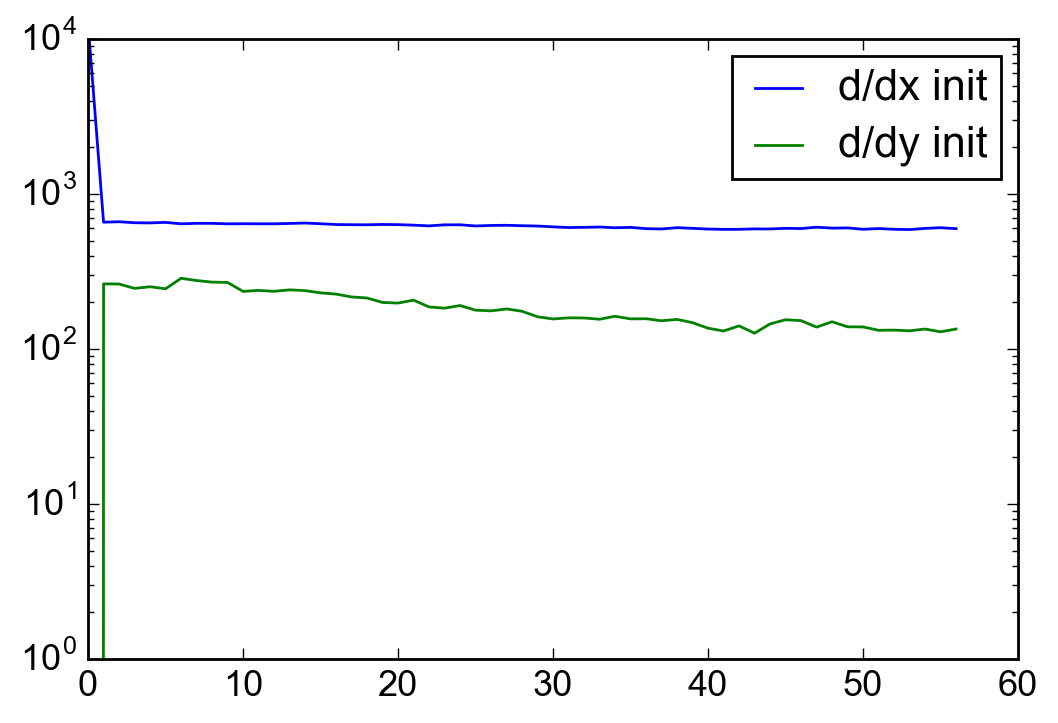

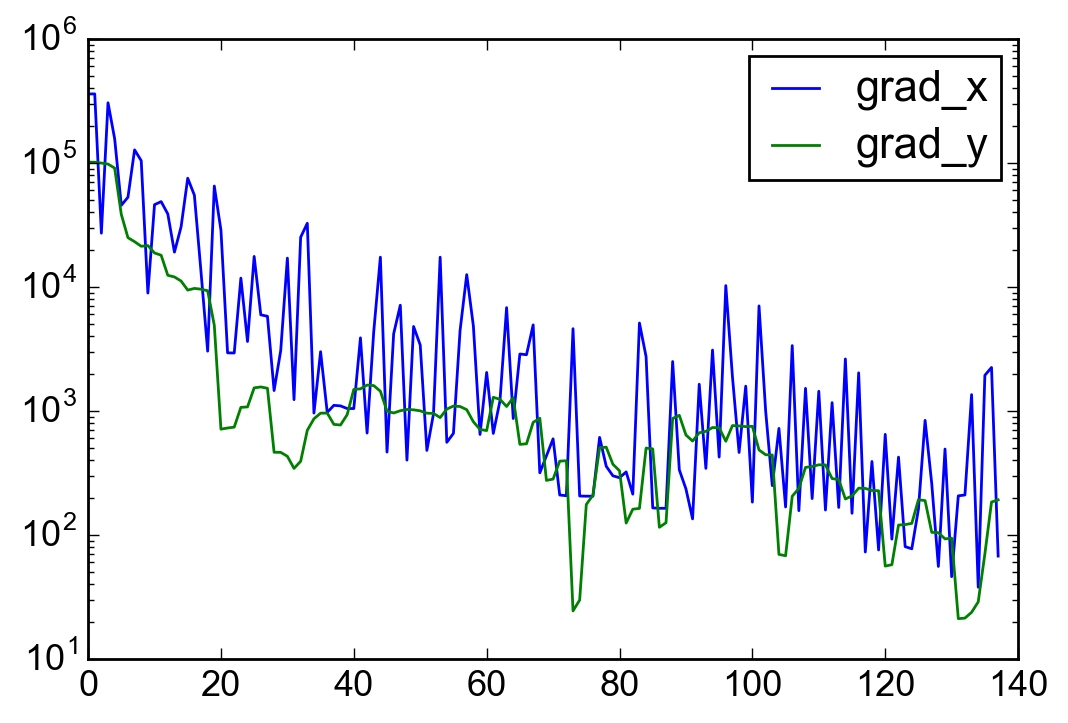

In [21]:
import matplotlib.gridspec as gridspec
%matplotlib inline
#%matplotlib notebook

save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Single electron loading"
sub_dir = r"170309_150338_M018V6_Greater_Trap_Area_V6.3_res_guard_sweep"

dbin = 0.006E-6
bins = np.arange(-0.80E-6, 0.80E-6+dbin, dbin)
save = False

converged, energy, num_trapped_electrons = list(), list(), list()
with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
    print("Directory: %s" % sub_dir)
    k = 0
    
    Vresguard = f["Vrg"][()]
    trap_grad_x_i, trap_grad_x_f, trap_grad_y_i, trap_grad_y_f = list(), list(), list(), list()
    
    for step in f.keys():
        if "step" in step:
            electron_ri = f[step + "/electron_final_coordinates"][()]
            xi, yi = anneal.r2xy(electron_ri)
            energy.append(f[step+"/final_energy"][()])

            valid_solution = f[step + "/solution_converged"][()]
            converged.append(valid_solution)

            if valid_solution:
                electron_hist, bin_edges = np.histogram(xi, bins=bins)
            else:
                electron_hist = np.zeros(len(electron_hist))

            if k == 0:
                electron_histogram = electron_hist
            else:
                electron_histogram = np.vstack((electron_histogram, electron_hist))

            k += 1
            
            initial_jac = f[step + "/initial_jacobian"][()]
            final_jac = f[step + "/final_jacobian"][()]
            
            trap_electrons_mask = np.intersect1d(np.where(xi > -1.2E-6)[0], np.where(xi < 1.2E-6)[0])
            if len(trap_electrons_mask) > 0: 
                trap_grad_x_i.append(np.amax(initial_jac[2*trap_electrons_mask]))
                trap_grad_x_f.append(np.amax(final_jac[2*trap_electrons_mask]))
                trap_grad_y_i.append(np.amax(initial_jac[2*trap_electrons_mask+1]))
                trap_grad_y_f.append(np.amax(final_jac[2*trap_electrons_mask+1]))
            else: 
                trap_grad_x_i.append(np.inf)
                trap_grad_x_f.append(np.inf)
                trap_grad_y_i.append(np.inf)
                trap_grad_y_f.append(np.inf)
            
    plt.figure()
    plt.plot(trap_grad_x_i, label="d/dx init")
    #plt.plot(trap_grad_x_f, label="d/dx final")
    #plt.plot(trap_grad_y_f, label="d/dy final")
    plt.plot(trap_grad_y_i, label="d/dy init")
    plt.yscale('log')
    plt.legend(loc=0)
    plt.ylim(1E0, 1E4)
    
    if 1:
        step = 57
        rs = f['step_%04d/x_during_simulation'%step]
        jac = f['step_%04d/jac_during_simulation'%step]

        plt.figure()
        plt.plot(np.amax(jac[:,::2], axis=1), label='grad_x')
        plt.plot(np.amax(jac[:,1::2], axis=1), label='grad_y')
        plt.legend(loc=0)
        plt.yscale('log')
        
        for k in tqdm(range(np.shape(rs)[0])):
            fig = plt.figure(figsize=(6.5,3.))
            plt.plot(rs[k,::2]*1E6, rs[k,1::2]*1E6, 'o', color='deepskyblue')
            plt.xlim(-4, 8)
            plt.ylim(-4, 4)
            plt.ylabel("$y$ ($\mu$m)")
            plt.title("Resonator guard = %.3f V"%Vresguard[step])
            common.save_figure(fig, save_path=os.path.join(save_path, sub_dir, "Annealing"))
            plt.close(fig)

    if 1:    
        for step in range(k):
            Vres, Vtrap, Vrg, Vtg = f["Vres"][()], f["Vtrap"][()], f["Vrg"][()][step], f["Vtg"][()]

            potential = Vres * f["resonator"][()] + Vtrap * f["trap"][()] + Vrg * f["res_guard"][()] + \
                        Vtg * f["trap_guard"][()]
            xpoints, ypoints = f["xpoints"][()], f["ypoints"][()]

            electrons = f["step_%04d"%step + "/electron_final_coordinates"][()]

            #gs = gridspec.GridSpec(2, 1, width_ratios=[1, 1]) 

            fig = plt.figure(figsize=(6.5,7.5))
            #fig, ax = plt.subplots(2, 1, figsize=(6.5, 6.5) )
            plt.subplot(211)
            common.configure_axes(13)
            colors = plt.pcolormesh(xpoints*1E6, ypoints*1E6, potential, cmap=plt.cm.RdYlBu)

            PP = anneal.PostProcess()
            PP.draw_from_dxf(filename=r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/V6.3/all_electrodes.dxf", 
                             **{'color' : 'black', 'lw' : 0.75, 'alpha' : 0.75})

            plt.plot(electrons[::2]*1E6, electrons[1::2]*1E6, 'o', color='deepskyblue')
            plt.xlim(-4, 8)
            plt.ylim(-4, 4)
            plt.ylabel("$y$ ($\mu$m)")
            plt.title("Resonator guard = %.3f V"%Vrg)

            ctr_idx = int(np.shape(ypoints)[0]/2)
            idcs = list()
            for xs in electrons[::2]: 
                idcs.append(common.find_nearest(xpoints[ctr_idx], xs))

            plt.subplot(212)
            plt.plot(xpoints[ctr_idx,:]*1E6, potential[ctr_idx,:], color='k')
            plt.xlim(-4, 8)
            plt.xlabel("$x$ ($\mu$m)")
            plt.ylabel("Electrostatic potential (-eV)")
            #plt.title("Resonator guard = %.3f V"%Vrg)
            plt.ylim(-0.7, -0.55)

            electrons_x, electrons_y = electrons[::2], electrons[1::2]
            TS = anneal.TrapAreaSolver(xpoints[0,:], ypoints[:,0], potential.T)
            interactions = TS.Vee(electrons_x, electrons_y)/1.602E-19
            np.fill_diagonal(interactions, 0)
            mu = list()
            el = 0
            for electron_x, electron_y in zip(electrons[::2], electrons[1::2]):
                mu.append(np.sum(interactions[el,:]) + TS.Velectrostatic(electron_x, electron_y)/1.602E-19)
                el += 1

            plt.plot(electrons_x*1E6, np.array(mu), 'o', color='deepskyblue')
            
            common.save_figure(fig, save_path=os.path.join(save_path, sub_dir, "2D slice"))
            plt.close(fig)
        
#         trap_mask = np.logical_and(electrons[::2] > -1.2E-6, electrons[::2] < 1.2E-6)
#         trap_electrons_x, trap_electrons_y = electrons[::2][trap_mask], electrons[1::2][trap_mask]
#         resonator_mask = np.where(electrons[::2] > 1.2E-6)[0]
#         res_electrons_x, res_electrons_y = electrons[::2][resonator_mask], electrons[1::2][resonator_mask]

#         res_interactions = TS.Vee(res_electrons_x, res_electrons_y)/1.602E-19
#         np.fill_diagonal(res_interactions, 0)
#         mu = list()
#         el = 0
#         for res_electron_x, res_electron_y in zip(res_electrons_x, res_electrons_y):
#             mu.append(np.sum(res_interactions[el,:]) + TS.Velectrostatic(res_electron_x, res_electron_y)/1.602E-19)
#             el += 1

#         plt.plot(res_electrons_x*1E6, np.array(mu), 'o', color='deepskyblue')

#         trap_interactions = TS.Vee(trap_electrons_x, trap_electrons_y)/1.602E-19
#         np.fill_diagonal(trap_interactions, 0)
#         el = 0
#         mu = list()
#         for trap_electron_x, trap_electron_y in zip(trap_electrons_x, trap_electrons_y):
#             mu.append(np.sum(trap_interactions[el,:]) + TS.Velectrostatic(trap_electron_x, trap_electron_y)/1.602E-19)
#             el += 1

#         plt.plot(trap_electrons_x*1E6, np.array(mu), 'o', color='deepskyblue')

    
print("\tOut of %d simulations, %d did not converge..." % (len(Vresguard), len(Vresguard) - np.sum(converged)))

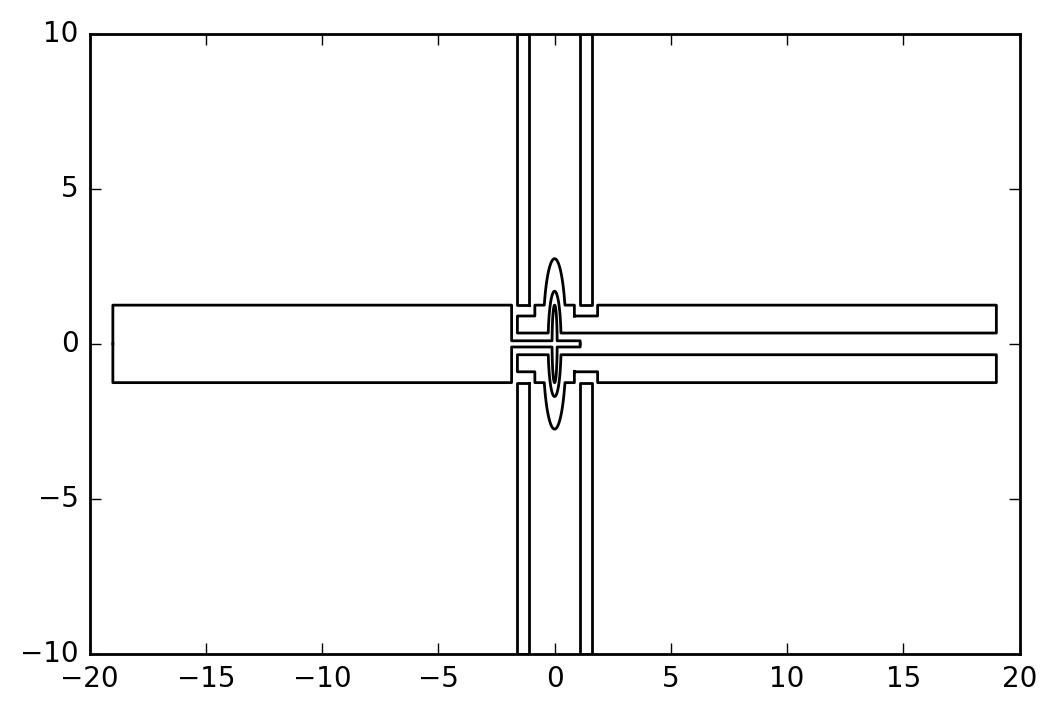

In [168]:
%matplotlib inline
import dxfgrabber
dxf=dxfgrabber.readfile("/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/V6.3/all_electrodes.dxf")

output=[entity for entity in dxf.entities]
for o in output:
    if o.dxftype == "LWPOLYLINE":
        list_of_vertices = o.points
        r = np.array(list_of_vertices)
        x = r[:,0]
        y = r[:,1]
        plt.plot(x, y, 'k')

In [4]:
TS.